## Bean Billiard

In [1]:
import os
import sys
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# sys.path.append("..")
from prepare_data import *
from boundary import *
from GFNN import GFNN

/Users/sankaran/Library/CloudStorage/OneDrive-UniversityofMassachusetts/Research/Chaotic Systems/chaotic-gfnn/Bean_Billiards


### Prepare Data

In [2]:
# Parameters for root finding
custom_rf = {'tol': 2E-12, 'maxiter': 50,
            'rootfind_open': rf.newton,
            'rootfind_bracketing': rf.bisect,
            'param_rootfind': 'bracketing'}

# Define boundary for bean billiard system
a = 0.16
b = 0.1
c = 2.0
d = 2.0

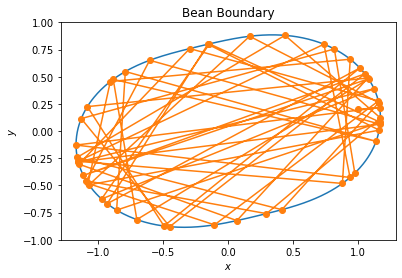

In [20]:
bdy = BeanBoundary(a,b,c,d, **custom_rf)

def plot_bean(bdy, seq_len, r0, theta):
    """Create side-by-side plots of trajectories with the same i.c.'s
        but different boundarys."""
    plt.title(r'Trajectories for $r_0$={0}, $\theta_0$={1}'
                 .format(r0, theta))
    v0 = np.array([np.cos(theta), np.sin(theta)])
    bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
    plt.plot(bdyline[0], bdyline[1])
    traj_line, = plt.plot([0, 0], [0, 0], 'o-')
    # Initialize plotline data
    state = init_state(r0, v0, bdy)
    missing = seq_len - state['trajectory'].shape[1]
    if missing > 0:
        propagate(state, missing)
        traj_line.set_xdata(state['trajectory'][0])
        traj_line.set_ydata(state['trajectory'][1])
    plt.title(str(bdy))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.ylim([-1, 1])

plot_bean(bdy, 50, np.array([1,0.2]), 0.1)

In [4]:
# Generate dataset using the boundary defined above
CURRENT_DIR = str(pathlib.Path(".").parent.absolute())
prefix = "chaotic_"
train_file_path, test_file_path = PrepareData(CURRENT_DIR + "/data",
                                              a = a,
                                              b = b,
                                              c = c,
                                              d = d,
                                              n_train=10000,
                                              n_test=100,
                                              seq_len=2,
                                              prefix=prefix,
                                              **custom_rf)

Training data already exists!
Testing data already exists!


### Initialize (load) the model

In [6]:
h = 0.5
parameters = {
    "dim": 2,
    "step_size": h,
    "train_file_path": train_file_path,
    "test_file_path": test_file_path,
    "batch_size": 200,
    "n_neurons": [4, 200, 100, 50, 20, 1],
    "lr": 1e-3,
}
# 
nn = GFNN(parameters)
# If saved checkpoint of GFNN exists, load GFNN from the checkpoint.
# Uncomment the following two lines if a loaded GFNN is deseired.
# if os.path.exists(STORAGE_DIR + "/checkpoint.pt"):
#     nn.Load(STORAGE_DIR)

### Train

In [7]:
# Train.
epochs = 20
nn.Train(epochs)

# Serialize the trained model.
STORAGE_DIR = CURRENT_DIR + "/" + prefix + f"({a},{b},{c},{d})" + "/"
if not os.path.exists(STORAGE_DIR):
    os.mkdir(STORAGE_DIR)
nn.Save(STORAGE_DIR)

Epoch 20: training loss=1.39e-01, testing loss=1.15e-01: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Text(0, 0.5, 'Training loss')

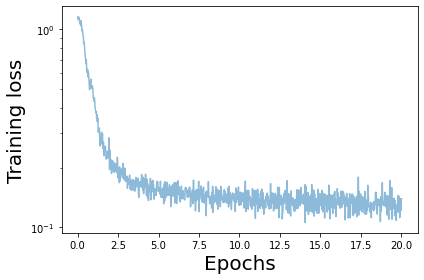

In [8]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy((np.arange(len(nn.loss_array))+1)/(nn.n_train/nn.args["batch_size"]), nn.loss_array, alpha=0.5)
ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Training loss", fontsize=20)

### Predict

In [17]:
def EvolveFlow(nn, r0, theta, seq_len):
    """
    Evolve the flow by the trained GFNN.
    Args:
        nn: the neural network
        r, v: the initial condition
        n: the steps to evolve
    """
    v0 = np.array([np.cos(theta), np.sin(theta)])
    r_traj = [r0]
    v_traj = [v0]
    r = r0
    v = v0
    for i in tqdm(range(seq_len)):
        r, v = nn.Predict(r, v)
        r_traj.append(r)
        v_traj.append(v)
    return np.array(r_traj), np.array(v_traj)

def EvolveBilliard(a, b, c, d, r0, theta, seq_len, **custom_rf):
    """
    Evolve the exact maps.
    Args:
        q, t: the initial condition.
        n: the steps to evolve.
        K: parameters in standard map.
    """
    # Generate seq_len steps of the billiard trajectory
    bdy = BeanBoundary(a,b,c,d, **custom_rf)
    v0 = np.array([np.cos(theta), np.sin(theta)])
    state = init_state(r0, v0, bdy)
    missing = seq_len - state['trajectory'].shape[1]
    if missing > 0:
        propagate(state, missing)
    pos_trajectory = state['trajectory'].T
    v_trajectory = state['velocity'].T
    return pos_trajectory, v_trajectory
    # pspan = [p]
    # tspan = [t]
    # for i in tqdm(range(n)):
    #     p, t = StandardMap(p, t, K)
    #     p = np.fmod(p+2*np.pi, 2*np.pi)
    #     t = np.fmod(t+2*np.pi, 2*np.pi)
    #     pspan.append(p)
    #     tspan.append(t)
    # return np.array(pspan), np.array(tspan)



#### Evolve the flow

In [18]:
# Initial condition for prediction
seq_len = 10000

r0 = np.array([1.0,0.2])
theta = 0.1
r_traj_pred, _ = EvolveFlow(nn, r0, theta, seq_len)


100%|██████████| 10000/10000 [00:33<00:00, 296.89it/s]


In [23]:
r_traj_exact, _ = EvolveBilliard(a, b, c, d, r0, theta, seq_len, **custom_rf)

#### Plot

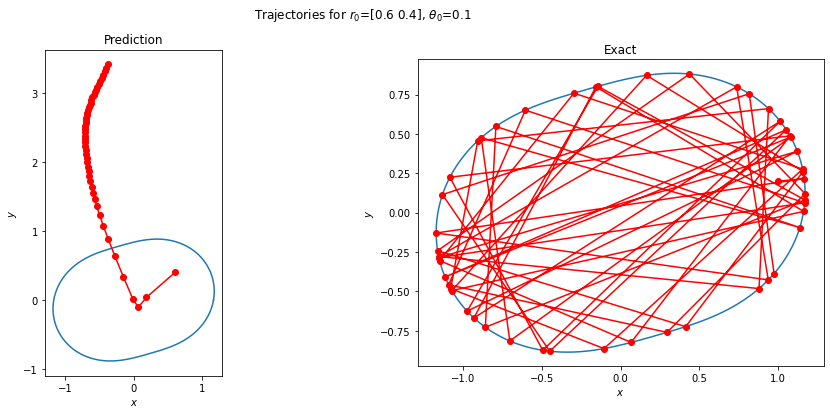

In [35]:
def compare_trajectories(bdy, r_traj_pred, r_traj_exact, r0, theta, seq_len):
    """Create side-by-side plots of trajectories with the same i.c.'s
        but different boundarys."""
    fig, axlist = plt.subplots(1, 2, figsize=np.array([16,6]))
    fig.suptitle(r'Trajectories for $r_0$={0}, $\theta_0$={1}'
                 .format(r0, theta))
    v0 = np.array([np.cos(theta), np.sin(theta)])
    for ax, traj, title in zip(axlist, [r_traj_pred, r_traj_exact], ["Prediction", "Exact"]):
        bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
        ax.plot(bdyline[0], bdyline[1])
        ax.plot(traj[:50,0], traj[:50,1], 'o-')
        ax.set_title(title)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_aspect('equal')
        # ax.set_ylim([-1, 1])

bdy = BeanBoundary(a,b,c,d, **custom_rf)
compare_trajectories(bdy, r_traj_pred, r_traj_exact, r0, theta, seq_len = 50)